# CLIP Implementation on the Fashion Dataset

Assuming you've already downloaded a slice of the image dataset, this is the next notebook to inspect.

## Installing required dependencies

The first step to experimenting is to make sure you have the right tools to experiment!

Run this cell to install necessary libraries and packages.

In [1]:
%pip install git+https://github.com/openai/CLIP.git
%pip install pillow pandas numpy torchvision

^C
Note: you may need to restart the kernel to use updated packages.


: 

: 

## Utilities

In [42]:
# Library & Package imports
import clip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Reading CSV files
pull_list = pd.read_csv('./sampled_image_list.csv')
styles = pd.read_csv('./styles.csv', on_bad_lines='skip')
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [2]:
# Loading basic CLIP model (ViT-B/32)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

model, preprocess = clip.load("ViT-B/32", device=device)  # Or "ViT-L/14" for better accuracy

Using device: cpu


## Zero-shot Classification on Single Samples

Our first benchmark for CLIP is a zero-shot classification on a random image sample. This is pretty straightforward: we feed an image and a set of text (here referred to as "prompts"), which are both encoded to produce a percentage probability for each prompt. Basically, CLIP tries to assess how many % chance that the input image matches each prompt.

See **2nd cell onwards** for usage and results.

**TIP: Try different numbers in SEED to get a different image every time**

In [3]:
def get_feature_name(id, *features):
    names = []
    for feature in features:
        names.append(styles.loc[styles['id'] == id, feature].values[0])
    return " ".join(names)


def zero_shot_single_image_test(seed=42):
    SINGLE_TEST_ID = pull_list.sample(n=1, random_state=seed)['id'].values[0]
    ALT_SINGLE_TEST_ID = pull_list.sample(n=1, random_state=seed*2)['id'].values[0]  # Alternative ID for testing


    prompts = [
        get_feature_name(SINGLE_TEST_ID, 'productDisplayName'),                 #  Full display name
        get_feature_name(SINGLE_TEST_ID, 'gender', 'usage', 'articleType'),     #  Gender + Usage + article type
        get_feature_name(SINGLE_TEST_ID, 'baseColour', 'articleType'),          #  Colour + article type
        get_feature_name(ALT_SINGLE_TEST_ID, 'productDisplayName'),             #  Random alternative: Full display name
        get_feature_name(ALT_SINGLE_TEST_ID, 'season', 'articleType'),          #  Random alternative: Season + article type
        get_feature_name(ALT_SINGLE_TEST_ID, 'baseColour', 'articleType'),      #  Random alternative: Colour + article type
    ]

    img_source = Image.open(f"./raw_images/{SINGLE_TEST_ID}.jpg")

    image = preprocess(img_source).unsqueeze(0).to(device)
    text = clip.tokenize(prompts).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

    # Normalize and compute similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    # Predict and print results
    print("Label probabilities:\n")
    for i, prob in enumerate(similarity[0]):
        print(f"\t{prompts[i]}: {prob.item()*100:.2f}%")

    # Display the image
    plt.imshow(img_source)
    plt.axis('off')
    plt.show()

Label probabilities:

	Lotto Unisex Shine Black Slippers: 27.35%
	Unisex Casual Flip Flops: 55.63%
	Black Flip Flops: 14.53%
	Rockport Men Arratoon Black Shoe: 0.06%
	Summer Formal Shoes: 2.05%
	Black Formal Shoes: 0.38%


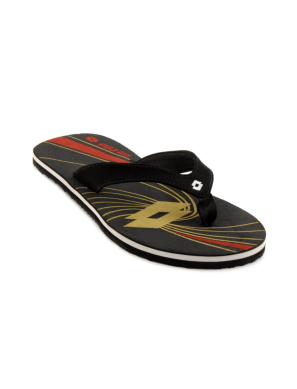

In [4]:
zero_shot_single_image_test(seed=420)

Label probabilities:

	Catwalk Women Black Wedges: 91.20%
	Women Casual Heels: 8.49%
	Black Heels: 0.31%
	Doodle Kids Boy Striped Blue Shorts: 0.00%
	Summer Shorts: 0.00%
	Blue Shorts: 0.00%


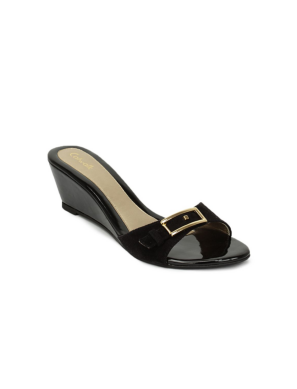

In [5]:
zero_shot_single_image_test(seed=123456789)

Label probabilities:

	Jealous 21 Women Blue Top: 74.11%
	Women Casual Tops: 24.74%
	Blue Tops: 0.53%
	Lee Men Check Blue Shirts: 0.02%
	Fall Shirts: 0.11%
	Blue Shirts: 0.50%


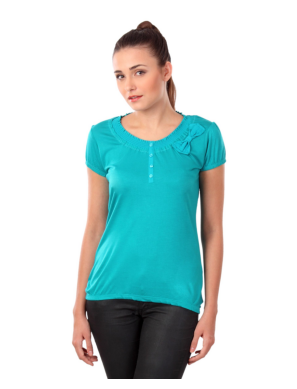

In [6]:
zero_shot_single_image_test(seed=31102025)

In this benchmark, we tested 3 different images with a common format for text prompts:
- Pattern (1): the product's true display name
- Pattern (2): the product's true target gender + usage + article type
- Pattern (3): the product's true colour + article type
- Pattern (4): a different (false) product's full display name
- Pattern (5): the false product's season + article type
- Pattern (6): the false alternative product's colour + article type

Overall, CLIP made some very some solid guesses on which of the 5 prompts are the most likely label for a few test images. Typically, CLIP would assign the highest probablity to Pattern (1), then Pattern (2) and (3). The more generic and decomposed Pattern (1) is, the better a candidate it becomes for the model to choose as the most probable description.

By coincidence, two of the images we had tested on each had a false product similar in class (e.g. [true] women's blue top vs [false] men check blue shirt). This allowed for an interesting exploration into CLIP's capabilities in disambiguing similar prompts:
- For *Jealous 21 Women Blue Top*, the true colour + type label "blue tops" was 0.3% higher in probablity than the false counterpart "blue shirts". This implies CLIP can discern between a generic shirt and a top piece - two pieces of apparel that are analogous to each other.

Since Pattern (1) always includes a brand name at the start, performance is sometimes hindered since brand names are not always key to identifying what type a piece of apparel is, leading to the introduction of noise in the encoding. In one example, CLIP chose *Unisex Casual Flip Flops* over *Lotto Unisex Shine Black Slippers* in terms of likeliness. This shows that CLIP is better designed to identify the visual aspects of an object, rather than its nominal properties.

## Using CLIP to Train a Classification Model

In [54]:
# CONFIGS
BATCH_SIZE = 32
LABEL_COL = 'subCategory' 

label_mapping = {label: idx for idx, label in enumerate(styles[LABEL_COL].unique())}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

class ClothingDataset(Dataset):
    def __init__(self,
                 index_csv='./sampled_image_list.csv',
                 metadata_csv='styles.csv',
                 label_col=LABEL_COL,
                 transform=None,
                 img_dir='./raw_images/',
                 reduced=False):
        self.index_df = pd.read_csv(index_csv, on_bad_lines='skip')
        metadata_df = pd.read_csv(metadata_csv, on_bad_lines='skip')

        # Merge on id to get labels
        self.data = pd.merge(self.index_df, metadata_df, on='id', how='inner')
        self.data = self.data.drop(['link'], axis=1)

        # Crop to first 10% of samples for faster training (optional)
        if reduced:
            self.data = self.data.sample(frac=0.1, random_state=42).reset_index(drop=True)

        self.labels = self.data[label_col].map(label_mapping).values
        self.image_ids = self.data['id'].values
        self.transform = transform
        self.target_transform = None
        self.img_dir = img_dir
        self.num_classes = len(np.unique(self.labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['filename']
        image = Image.open(self.img_dir + img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

**CAUTION: FEATURE EXTRACTION TAKES A WHILE TO COMPLETE**

In [79]:
# Step 1: Load CLIP and preprocess
model.eval()  # Freeze for feature extraction

# Step 2: Load and split data (assume 3k samples)
full_dataset = ClothingDataset(transform=preprocess, reduced=False)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Step 3: Extract features (batched for efficiency)
def extract_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset=dataset,
                                                    batch_size=BATCH_SIZE),
                                         desc="Extracting features"):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)
    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)

print(f"Extracted {len(train_features)} train features (shape: {train_features.shape})")

Extracting features: 100%|██████████| 24/24 [00:38<00:00,  1.58s/it]

Extracted 3058 train features (shape: (3058, 512))


In [80]:
# Perform logistic regression
# Hyperparam grid: Tune C (1/l2_reg) and solver (for stability)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Low C = strong reg (like weight_decay=1e-3 to 1e-5)
    'solver': ['lbfgs'],  # lbfgs for multi-class
    'max_iter': [1000]  # Increase if convergence warnings
}
classifier = LogisticRegression(random_state=0, multi_class='multinomial', verbose=1)

# Grid search with 5-fold CV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)  # n_jobs=-1 for parallel on CPU
grid_search.fit(train_features, train_labels)

# Best model and results
best_model = grid_search.best_estimator_
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.2%}")

# Evaluate using the logistic regression classifier
test_predictions = best_model.predict(test_features)
train_predictions = best_model.predict(train_features)

# Decode predictions back to labels
decoded_test_predictions = [reverse_label_mapping[pred] for pred in test_predictions]
decoded_test_labels = [reverse_label_mapping[label] for label in test_labels]

# Accuracy report
test_acc = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy for subcategories: {test_acc:.2%}")

print("Classification Report on test set:\n")
print(classification_report(decoded_test_predictions, decoded_test_labels),"\n\n")

c:\Users\chita\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best params: {'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
Best CV accuracy: 95.49%
Test Accuracy for subcategories: 95.42%
Classification Report on test set:

                          precision    recall  f1-score   support

             Accessories       0.83      1.00      0.91         5
                    Bags       1.00      0.96      0.98        50
                   Belts       0.93      1.00      0.97        14
              Bottomwear       1.00      0.95      0.97        39
               Cufflinks       0.50      1.00      0.67         1
                   Dress       0.62      1.00      0.77         5
                    Eyes       0.00      0.00      0.00         0
                 Eyewear       1.00      1.00      1.00        21
              Flip Flops       0.80      0.80      0.80        20
               Fragrance       1.00      0.83      0.91        12
              Free Gifts       0.00      0.00      0.00         0
                Headwear       1.00      1.00 

c:\Users\chita\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chita\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chita\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

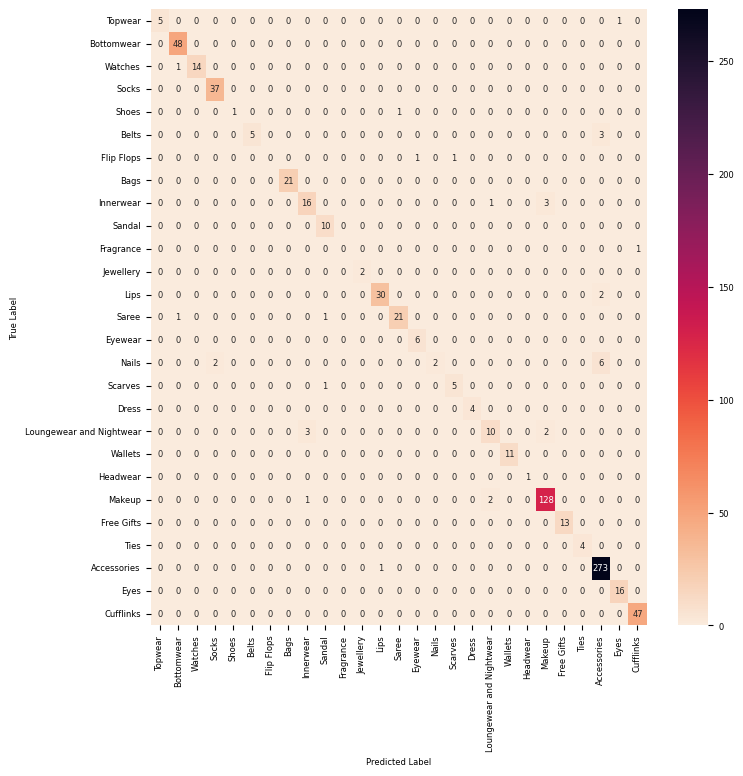

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl

# Confusion Matrix

cm = confusion_matrix(decoded_test_labels, decoded_test_predictions)

available_indicies = [idx for idx in reverse_label_mapping.keys() if idx in test_predictions or idx in test_labels]
available_labels = [reverse_label_mapping[idx] for idx in available_indicies]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
            xticklabels=available_labels,
            yticklabels=available_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

c:\Users\chita\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


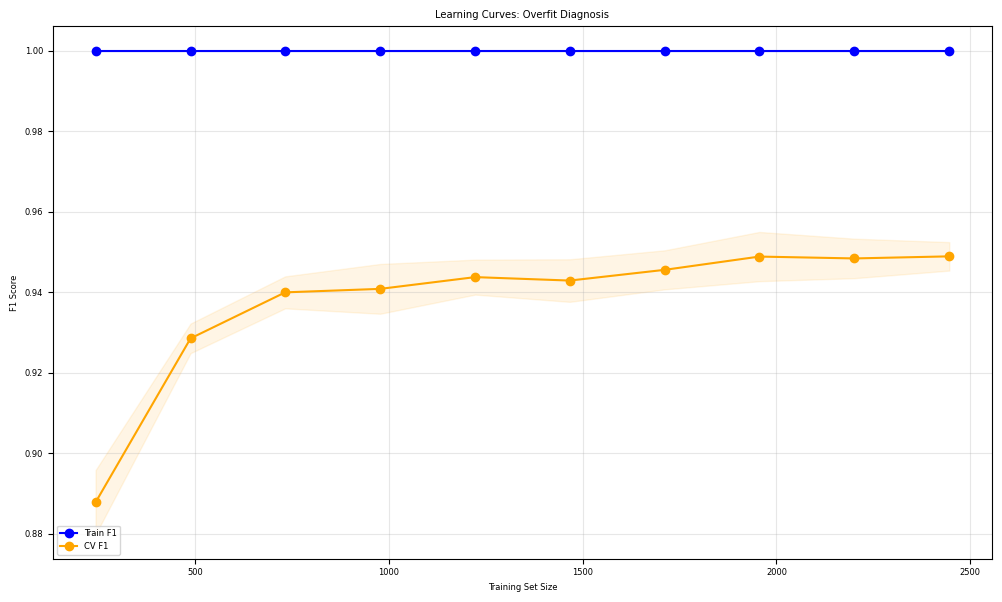

In [83]:
from sklearn.model_selection import learning_curve

# Learning Curve for Overfit Diagnosis
train_sizes, train_scores, val_scores = learning_curve(
    best_model, train_features, train_labels, cv=5, scoring='f1_weighted', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points from 10% to 100% data
    random_state=42
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Train F1')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', color='orange', label='CV F1')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color='blue')
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                 np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1, color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curves: Overfit Diagnosis')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()